# H3 Full Panel Construction (Selection Bias Accounted For)
__Note: Do Run 03_weather.ipynb first for weather data__

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from dataclasses import dataclass
import psutil
import pickle
import h3
sns.set_style('whitegrid')

## 1. Notebook configuration, reproducibility, and logging

In [11]:
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class Config:
    h3_res: int = 8
    baseline_window: int = 30  # hours rolling window per H3 for baseline risk
    lag: int = 1               # lag by 1 hour before computing baseline
    save_path: str = '../data/h3_full_panel_res8.csv'

cfg = Config()

def env_checks():
    mem = psutil.virtual_memory()
    logger.info(f"Memory available: {mem.available/1e9:.2f} GB")
    logger.info(f"Using H3 version: {h3.__version__}")
env_checks()

[INFO] Memory available: 5.16 GB
[INFO] Using H3 version: 4.3.1


## 2. Load existing dense panel and weather, infer index sets


In [12]:
panel = pd.read_csv('../data/h3_panel_res8.csv')
weather = pd.read_csv('../data/nyc_weather_hourly.csv')

# Normalize date/hour types
panel['date'] = pd.to_datetime(panel['date']).dt.date
weather['date'] = pd.to_datetime(weather['date']).dt.date

print('Panel columns:', panel.columns.tolist())
h3_candidates = ['h3_index','h3_cell','h3']
h3_col = next((c for c in h3_candidates if c in panel.columns), None)
assert h3_col is not None, 'No H3 index column found in panel (expected one of: h3_index, h3_cell, h3)'

unique_h3 = sorted(panel[h3_col].dropna().unique())
date_hour = weather[['date','hour']].drop_duplicates().sort_values(['date','hour'])

logger.info(f"Dense panel rows: {len(panel):,}")
logger.info(f"Unique H3 cells observed: {len(unique_h3):,}")
logger.info(f"Distinct (date, hour) from weather: {len(date_hour):,}")

[INFO] Dense panel rows: 334,804
[INFO] Unique H3 cells observed: 1,135
[INFO] Distinct (date, hour) from weather: 34,248


Panel columns: ['h3', 'date', 'hour', 'accidents_count', 'accident_indicator', 'total_injured', 'total_killed', 'day_of_week', 'is_weekend', 'month', 'is_rush_hour', 'Baseline_Risk', 'Traffic_Proxy']


## 3. Build full cartesian panel (H3 × date × hour)


In [13]:
full_index = pd.MultiIndex.from_product([unique_h3, date_hour['date'].unique(), date_hour['hour'].unique()],
                                         names=['h3_index','date','hour'])
full_panel = pd.DataFrame(index=full_index).reset_index()

logger.info(f"Full cartesian size: {len(full_panel):,} rows")
display(full_panel.head())

[INFO] Full cartesian size: 38,871,480 rows


,h3_index,date,hour
0,882a100003fffff,2022-01-01,0
1,882a100003fffff,2022-01-01,1
2,882a100003fffff,2022-01-01,2
3,882a100003fffff,2022-01-01,3
4,882a100003fffff,2022-01-01,4


## 4. Merge crash counts; fill missing with zeros

In [14]:
dense_cols = [h3_col,'date','hour','accidents_count']
dense = panel[dense_cols].copy()
dense['date'] = pd.to_datetime(dense['date']).dt.date
full_panel = full_panel.merge(dense.rename(columns={h3_col:'h3_index'}), on=['h3_index','date','hour'], how='left')
full_panel['accidents_count'] = full_panel['accidents_count'].fillna(0).astype(int)
full_panel['accident_indicator'] = (full_panel['accidents_count'] > 0).astype(int)

logger.info(f"Crash coverage after merge: {full_panel['accident_indicator'].sum():,} accident hours out of {len(full_panel):,}")
display(full_panel.head(10))

[INFO] Crash coverage after merge: 334,804 accident hours out of 38,871,480


,h3_index,date,hour,accidents_count,accident_indicator
0,882a100003fffff,2022-01-01,0,0,0
1,882a100003fffff,2022-01-01,1,0,0
2,882a100003fffff,2022-01-01,2,0,0
3,882a100003fffff,2022-01-01,3,0,0
4,882a100003fffff,2022-01-01,4,0,0
5,882a100003fffff,2022-01-01,5,0,0
6,882a100003fffff,2022-01-01,6,0,0
7,882a100003fffff,2022-01-01,7,0,0
8,882a100003fffff,2022-01-01,8,0,0
9,882a100003fffff,2022-01-01,9,0,0


## 5. Recreate time features needed for confounders

In [ ]:
dt = pd.to_datetime(full_panel['date'].astype(str) + ' ' + full_panel['hour'].astype(int).astype(str) + ':00')
full_panel['day_of_week'] = dt.dt.weekday
full_panel['is_weekend'] = (full_panel['day_of_week'] >= 5).astype(int)
full_panel['month'] = dt.dt.month

# Insights from 01*.ipynb where 16 had the highest crashes and rush_hours don't include WEEKENDS obv
full_panel['is_rush_hour'] = ((dt.dt.hour.isin([7,8,9,16,17,18])) & (~full_panel['is_weekend'].astype(bool))).astype(int) 

# Simple traffic proxy
full_panel['Traffic_Proxy'] = 1 + full_panel['is_rush_hour']

## 6. Compute Baseline_Risk per H3 with lag and rolling mean

In [16]:
full_panel = full_panel.sort_values(['h3_index','date','hour'])
full_panel['accidents_count_shifted'] = full_panel.groupby('h3_index')['accidents_count'].shift(cfg.lag)
full_panel['Baseline_Risk'] = (
    full_panel.groupby('h3_index')['accidents_count_shifted']
    .rolling(cfg.baseline_window, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)
full_panel.drop(columns=['accidents_count_shifted'], inplace=True)

# Sanity checks
assert not full_panel['Baseline_Risk'].isna().all(), "Baseline_Risk computed incorrectly: all NaN"
logger.info("Baseline_Risk computed with lag and rolling mean.")

[INFO] Baseline_Risk computed with lag and rolling mean.


## 7. Merge weather and finalize

In [17]:
full_panel = full_panel.merge(weather[['date','hour','rain_flag','precipitation']], on=['date','hour'], how='left')
full_panel['rain_flag'] = full_panel['rain_flag'].fillna(0).astype(int)

logger.info(f"Weather coverage: missing rain_flag rows = {full_panel['rain_flag'].isna().sum()}")
logger.info(f"Final panel shape: {full_panel.shape}")
display(full_panel.sample(10))

[INFO] Weather coverage: missing rain_flag rows = 0
[INFO] Final panel shape: (38871480, 13)


,h3_index,date,hour,accidents_count,accident_indicator,day_of_week,is_weekend,month,is_rush_hour,Traffic_Proxy,Baseline_Risk,rain_flag,precipitation
11687805,882a100c4bfffff,2023-01-20,21,0,0,4,0,1,0,1,0.033333,0,0.0
36211406,882a107665fffff,2023-04-15,14,0,0,5,1,4,0,1,0.000000,0,0.0
9877919,882a100ac3fffff,2023-08-27,23,0,0,6,1,8,0,1,0.000000,0,0.0
26679583,882a1060e9fffff,2022-01-17,7,0,0,0,0,1,1,2,0.000000,0,0.0
19907788,882a100ec5fffff,2023-02-09,4,0,0,3,0,2,0,1,0.000000,0,0.0
37629367,882a107713fffff,2024-11-10,7,0,0,6,1,11,0,1,0.000000,0,0.0
31239320,882a10728dfffff,2022-08-03,8,0,0,2,0,8,1,2,0.000000,0,0.0
38187413,882a10773dfffff,2022-02-07,5,0,0,0,0,2,0,1,0.000000,0,0.0
4524524,882a100507fffff,2022-06-07,20,0,0,1,0,6,0,1,0.033333,0,0.0
10187732,882a100ad7fffff,2023-11-01,20,0,0,2,0,11,0,1,0.033333,0,0.0


## 8. Diagnostics: class balance and basic plots

Class balance and rain prevalence:
  Accident hours: 334,804 / 38,871,480 (0.86%)
  Rain hours: 4,182,475 / 38,871,480 (10.76%)
  Mean accidents_count: 0.0087


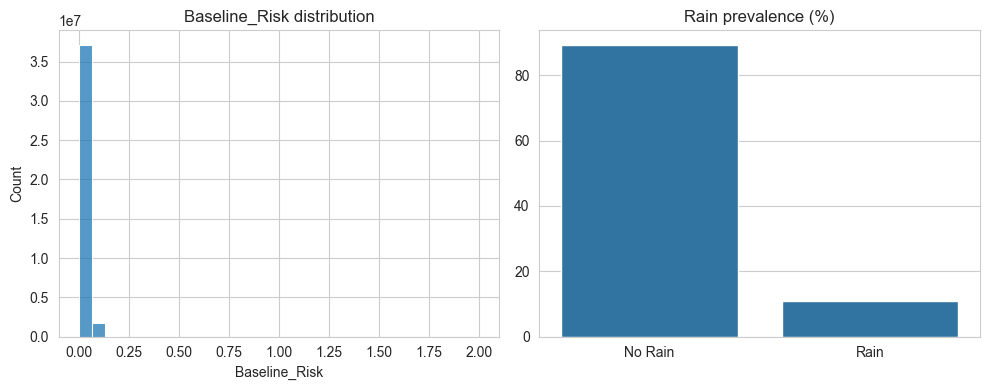

In [18]:
print("Class balance and rain prevalence:")
print(f"  Accident hours: {full_panel['accident_indicator'].sum():,} / {len(full_panel):,} ({full_panel['accident_indicator'].mean()*100:.2f}%)")
print(f"  Rain hours: {full_panel['rain_flag'].sum():,} / {len(full_panel):,} ({full_panel['rain_flag'].mean()*100:.2f}%)")
print(f"  Mean accidents_count: {full_panel['accidents_count'].mean():.4f}")

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.histplot(full_panel['Baseline_Risk'], bins=30, ax=axes[0])
axes[0].set_title('Baseline_Risk distribution')
sns.barplot(x=['No Rain','Rain'], y=[(1-full_panel['rain_flag'].mean())*100, full_panel['rain_flag'].mean()*100], ax=axes[1])
axes[1].set_title('Rain prevalence (%)')
plt.tight_layout()
plt.show()

## 9. Save final full panel


In [19]:
full_panel.to_csv(cfg.save_path, index=False)
logger.info(f"Saved full panel to {cfg.save_path}")
print(full_panel.shape)

[INFO] Saved full panel to ../data/h3_full_panel_res8.csv


(38871480, 13)
